In [28]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy, estimation_error
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression
from sklearn.metrics import r2_score
from pyuoi.linear_model import UoI_Lasso

In [64]:
# %load ../loaders/datgen.py
n_features = 500
n_samples = 2000

sigma = gen_covariance(n_features, 0, n_features, 1, 0)
beta = gen_beta2(n_features, n_features, sparsity = 0.2, betawidth = np.inf)
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, kappa = 100, 
									covariance = sigma, beta = beta)

In [3]:
import pycasso

In [4]:
from sklearn.linear_model.coordinate_descent import _alpha_grid

In [5]:
alphas = _alpha_grid(X, y, n_alphas = 48)

In [6]:
import sklearn

In [7]:
from sklearn.linear_model import Lasso

In [51]:
# sklearn
%timeit s = sklearn_lasso(alphas)

567 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
def sklearn_lasso(alphas):
    coefs = np.zeros((alphas.size, n_features))
    l = Lasso(warm_start = True)
    for i, alpha in enumerate(alphas):
        l.set_params(alpha = alpha)
        l.fit(X, y)
        coefs[i, :] = l.coef_.ravel()
    return coefs

In [9]:
def pycasso_lasso(alphas):
    s = pycasso.Solver(X, y, family = 'gaussian', penalty = 'l1', lambdas = alphas.tolist())
    s.train()
    return s

In [60]:
%timeit s = sklearn_lasso(alphas)

18.2 s ± 98.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%timeit s2 = pycasso_lasso(alphas)

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
545 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# Compare the coefficients
s = sklearn_lasso(alphas)
s2 = pycasso_lasso(alphas)

Training is over.


In [18]:
len(s)

48

In [19]:
s2.result['beta'].shape

(48, 500)

In [20]:
comp = [np.allclose(s[i].coef_.ravel(), s2.result['beta'][i, :]) for i in range(48)]

In [21]:
comp

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [23]:
np.count_nonzero(s2.result['beta'], axis = 1)

array([  0,   8,  14,  26,  35,  42,  50,  56,  61,  67,  73,  74,  76,
        78,  82,  85,  87,  90,  92,  92,  94,  98,  99, 100, 109, 116,
       129, 147, 163, 183, 202, 228, 252, 278, 298, 326, 344, 364, 377,
       402, 410, 425, 434, 444, 450, 453, 461, 466])

In [25]:
print([np.count_nonzero(s[i].coef_) for i in range(48)])

[1, 7, 14, 25, 35, 42, 50, 56, 61, 67, 73, 74, 76, 78, 82, 85, 87, 90, 92, 92, 94, 98, 99, 100, 109, 116, 129, 147, 163, 182, 201, 229, 250, 278, 296, 325, 346, 364, 378, 401, 409, 424, 434, 444, 450, 453, 461, 465]


In [ ]:
# Compare selection accuracy, r2, and estimation error

In [49]:
ee2, _ = estimation_error(beta.ravel(), s2.result['beta'])
sa2 = selection_accuracy(beta.ravel(), s2.result['beta'])
r2_2 = np.array([r2_score(y_test.ravel(), X_test @ s2.result['beta'][i, :].T) for i in range(48)])

In [51]:
ee1 = np.array([estimation_error(beta.ravel(), s[i].coef_)[0] for i in range(48)])
sa1 = np.array([selection_accuracy(beta.ravel(), s[i].coef_) for i in range(48)])
r2_1 = np.array([r2_score(y_test.ravel(), X_test @ s[i].coef_.T) for i in range(48)])

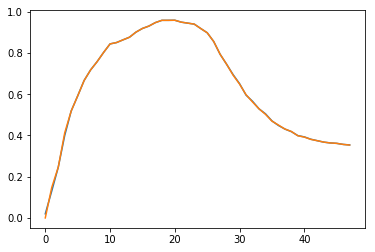

In [36]:
plt.plot(sa1)
plt.plot(sa2)

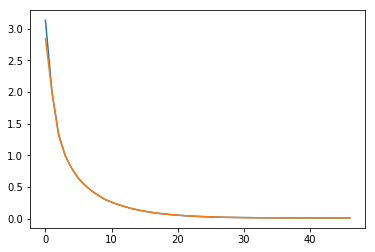

In [52]:
plt.plot(ee1[1:])
plt.plot(ee2[1:])

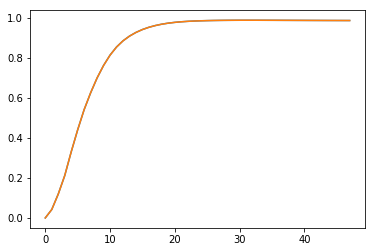

In [53]:
plt.plot(r2_1)
plt.plot(r2_2)

In [62]:
# Adjust data to allow same algorithm to solve the elastic net
def augment_data(X, y, lambda2):
    Xstar = 1/np.sqrt(1 + lambda2) * np.vstack([X, np.sqrt(lambda2) * np.eye(X.shape[1])])
    ystar = np.vstack([y, np.zeros(X.shape[1])])
    return Xstar, ystar

In [74]:
l1_ratios = np.array([0.1, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

In [80]:
en_alphas = np.zeros((len(l1_ratios), 48))
for i, l1_ratio in enumerate(l1_ratios):
    en_alphas[i, :] = _alpha_grid(X, y.ravel(), n_alphas = 48, l1_ratio = l1_ratio)

In [76]:
l1_ratios = l1_ratios[:, np.newaxis]

In [77]:
l1_ratios.shape

(7, 1)

In [81]:
l1 = np.multiply(l1_ratios, en_alphas)

In [83]:
l2 = np.multiply((1 - l1_ratios)/2, en_alphas)

In [84]:
l1

array([[1.14047739e+01, 9.84593337e+00, 8.50016009e+00, 7.33833136e+00,
        6.33530504e+00, 5.46937553e+00, 4.72180401e+00, 4.07641292e+00,
        3.51923592e+00, 3.03821564e+00, 2.62294273e+00, 2.26443063e+00,
        1.95492109e+00, 1.68771630e+00, 1.45703391e+00, 1.25788191e+00,
        1.08595064e+00, 9.37519472e-01, 8.09376349e-01, 6.98748232e-01,
        6.03241116e-01, 5.20788215e-01, 4.49605236e-01, 3.88151772e-01,
        3.35097962e-01, 2.89295714e-01, 2.49753861e-01, 2.15616715e-01,
        1.86145541e-01, 1.60702580e-01, 1.38737244e-01, 1.19774199e-01,
        1.03403083e-01, 8.92696231e-02, 7.70679690e-02, 6.65340755e-02,
        5.74399878e-02, 4.95889088e-02, 4.28109401e-02, 3.69594056e-02,
        3.19076772e-02, 2.75464351e-02, 2.37813013e-02, 2.05307979e-02,
        1.77245836e-02, 1.53019315e-02, 1.32104152e-02, 1.14047739e-02],
       [1.14047739e+01, 9.84593337e+00, 8.50016009e+00, 7.33833136e+00,
        6.33530504e+00, 5.46937553e+00, 4.72180401e+00, 4.07641

In [ ]:
# Not possible to parameterize equally, but can we get similar performance exploring the same number of total 
# hypyerparameters?

In [98]:
from sklearn.linear_model import ElasticNet

In [99]:
def sklearn_EN(X, y, l1_ratios):
    coefs = np.zeros((l1_ratios.size, 48, n_features))
    model = ElasticNet(warm_start = True)
    for i, l1_ratio in enumerate(l1_ratios):
        alphas = _alpha_grid(X, y, l1_ratio = l1_ratio, n_alphas = 48)
        for j, alpha in enumerate(alphas):
            model.set_params(l1_ratio = l1_ratio, alpha = alpha)
            model.fit(X, y)
            coefs[i, j, :] = model.coef_.ravel()
    return coefs

In [100]:
def picasso_EN(X, y, l2s, alpha):
    
    for l2 in l2s:
        xx, yy = augment_data(X, y, l2)
        s = pycasso.Solver(X, y, family = 'gaussian', penalty = 'l1', lambdas = alphas.tolist())

In [101]:
%timeit coefs = sklearn_EN(X, y, l1_ratios)

3.82 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
# Test the lbfgs solver
from pyuoi.lbfgs import fmin_lbfgs

In [152]:
def MSE_loss(beta, grad, X, y):
    
    loss = 1/(2 * y.size) * np.sum((y.ravel() - (X @ beta).ravel())**2)
    grad = 1/y.size * ((X.T @ X @ beta).ravel() - (X.T @ y).ravel())
    print(grad.shape)
    return loss

In [156]:
def lbfgs_lasso(X, y, alphas):
    
    coefs = np.zeros((alphas.size, n_features))
    warm_start = np.zeros(n_features)
    
    for i, alpha in enumerate(alphas):
        coefs[i, :] = fmin_lbfgs(MSE_loss, warm_start, args = (X, y), orthantwise_c = alpha)
        print(coefs[i, :])
        
    return coefs

In [157]:
coefs = lbfgs_lasso(X, y, alphas)

(500,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

(500,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

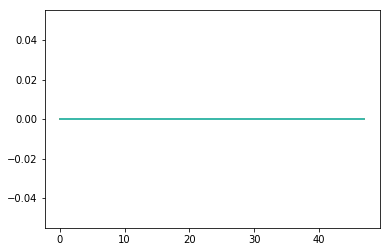

In [155]:
plt.plot(coefs)